# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 78 kB 6.5 MB/s 
     |████████████████████████████████| 462 kB 34.3 MB/s 
  Created wheel for adapt: filename=adapt-0.4.0-py3-none-any.whl size=101264 sha256=fbfde341323a00d1a578622f44070b69c19d35b9c3fba147e248a5a379b4a1c0
  Stored in directory: /root/.cache/pip/wheels/47/47/61/e923985c37a7075ec75c4b16295782354b1c5dd291d47a7637
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
BATCH_SIZE = 8
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

125

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_test1), "rb") as f:
    TCGA_test1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
with open(os.path.abspath(Target_dir_test2), "rb") as f:
    TCGA_test2 = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train1['train'] + TCGA_train2['train']
TCGA_train_labels = np.concatenate((TCGA_train1['train_label'],TCGA_train2['train_label']))
TCGA_test_data = TCGA_test1['test'] + TCGA_test2['test']
TCGA_test_labels = np.concatenate((TCGA_test1['test_label'],TCGA_test2['test_label']))

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (3200, 256, 256, 3)
The shape of TCGA_train_labels:  (3200,)
The shape of TCGA_test_data:  (3200, 256, 256, 3)
The shape of TCGA_test_labels:  (3200,)


In [ ]:
import gc
gc.collect()

200

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


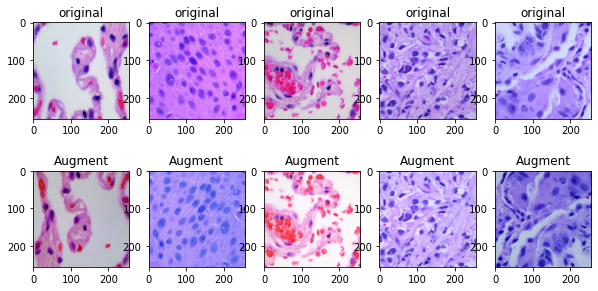

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

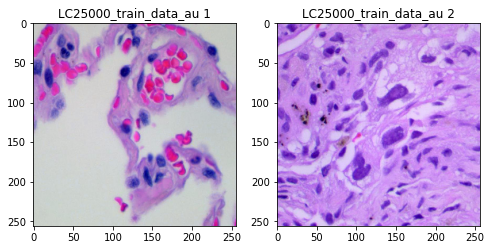

In [ ]:
# random show images
plt.subplots(1,2,figsize=(8,8))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.title("LC25000_train_data_au 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data_au 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

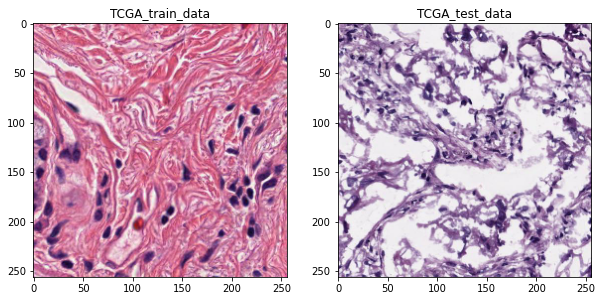

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_256.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 512)]     0         
                                                                 
 block5_conv1 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 8, 8, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data_au (source) shape: (3200, 256, 256, 3)
TCGA_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
50/50 [==============================] - 4s 71ms/step - loss: 2.1260 - acc: 0.6203 - val_loss: 2.4176 - val_acc: 0.3316
Epoch 2/5
50/50 [==============================] - 2s 50ms/step - loss: 1.0647 - acc: 0.7344 - val_loss: 1.6994 - val_acc: 0.4044
Epoch 3/5
50/50 [==============================] - 2s 50ms/step - loss: 0.6364 - acc: 0.8034 - val_loss: 1.6643 - val_acc: 0.4172
Epoch 4/5
50/50 [==============================] - 3s 51ms/step - loss: 0.4951 - acc: 0.8322 - val_loss: 1.6368 - val_acc: 0.4228
Epoch 5/5
50/50 [==============================] - 3s 52ms/step - loss: 0.4404 - acc: 0.8422 - val_loss: 1.7444 - val_acc: 0.4038
Epoch 1/100
50/50 [==============================] - 6s 89ms/step - loss: 0.4076 - acc: 0.8587 - val_loss: 1.5128 - val_acc: 0.4225
Epoch 2/100
50/50 [==============================] - 3s 68ms/step - loss: 0.3587 - acc: 0.8606 - val_loss: 1.5202 - val_acc: 0.4125
Epoch 3/100
50/50 [==============================] - 3s 67ms/step - loss: 0.3246 - acc

### Run 2


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
50/50 [==============================] - 7s 83ms/step - loss: 2.4930 - acc: 0.5881 - val_loss: 2.4323 - val_acc: 0.3625
Epoch 2/5
50/50 [==============================] - 3s 63ms/step - loss: 1.0350 - acc: 0.7366 - val_loss: 1.5982 - val_acc: 0.4453
Epoch 3/5
50/50 [==============================] - 3s 62ms/step - loss: 0.6682 - acc: 0.8037 - val_loss: 1.5522 - val_acc: 0.4466
Epoch 4/5
50/50 [==============================] - 3s 63ms/step - loss: 0.4841 - acc: 0.8413 - val_loss: 1.5487 - val_acc: 0.4437
Epoch 5/5
50/50 [==============================] - 3s 63ms/step - loss: 0.4676 - acc: 0.8378 - val_loss: 1.6132 - val_acc: 0.4363
Epoch 1/100
50/50 [==============================] - 8s 116ms/step - loss: 0.4054 - acc: 0.8662 - val_loss: 1.5960 - val_acc: 0.4087
Epoch 2/100
50/50 [==============================] - 5s 97ms/step - loss: 0.3758 - acc: 0.8591 - val_loss: 1.4917 - val_acc: 0.4112
Epoch 3/100
50/50 [==============================] - 5s 97ms/step - loss: 0.3015 - ac

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
50/50 [==============================] - 5s 83ms/step - loss: 2.3286 - acc: 0.5888 - val_loss: 2.2991 - val_acc: 0.3466
Epoch 2/5
50/50 [==============================] - 3s 64ms/step - loss: 0.9935 - acc: 0.7353 - val_loss: 1.4320 - val_acc: 0.4631
Epoch 3/5
50/50 [==============================] - 3s 63ms/step - loss: 0.6303 - acc: 0.8216 - val_loss: 1.6731 - val_acc: 0.4441
Epoch 4/5
50/50 [==============================] - 3s 63ms/step - loss: 0.5346 - acc: 0.8213 - val_loss: 1.5814 - val_acc: 0.4384
Epoch 5/5
50/50 [==============================] - 3s 64ms/step - loss: 0.4137 - acc: 0.8519 - val_loss: 1.7752 - val_acc: 0.4300
Epoch 1/100
50/50 [==============================] - 7s 118ms/step - loss: 0.4614 - acc: 0.8553 - val_loss: 1.4775 - val_acc: 0.4309
Epoch 2/100
50/50 [==============================] - 5s 98ms/step - loss: 0.3232 - acc: 0.8806 - val_loss: 1.6084 - val_acc: 0.4244
Epoch 3/100
50/50 [==============================] - 5s 98ms/step - loss: 0.3188 - ac

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
50/50 [==============================] - 5s 84ms/step - loss: 1.9360 - acc: 0.6156 - val_loss: 1.4210 - val_acc: 0.3869
Epoch 2/5
50/50 [==============================] - 3s 62ms/step - loss: 0.9108 - acc: 0.7616 - val_loss: 1.4238 - val_acc: 0.4588
Epoch 3/5
50/50 [==============================] - 3s 62ms/step - loss: 0.6176 - acc: 0.8169 - val_loss: 1.5365 - val_acc: 0.4566
Epoch 4/5
50/50 [==============================] - 3s 63ms/step - loss: 0.5117 - acc: 0.8372 - val_loss: 1.6141 - val_acc: 0.4494
Epoch 5/5
50/50 [==============================] - 3s 64ms/step - loss: 0.4379 - acc: 0.8453 - val_loss: 1.6147 - val_acc: 0.4484
Epoch 1/100
50/50 [==============================] - 7s 118ms/step - loss: 0.4102 - acc: 0.8669 - val_loss: 1.5434 - val_acc: 0.4231
Epoch 2/100
50/50 [==============================] - 5s 98ms/step - loss: 0.3631 - acc: 0.8659 - val_loss: 1.4396 - val_acc: 0.4150
Epoch 3/100
50/50 [==============================] - 5s 98ms/step - loss: 0.3013 - ac

### Run 5


In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
50/50 [==============================] - 5s 85ms/step - loss: 2.3542 - acc: 0.5944 - val_loss: 2.1951 - val_acc: 0.3591
Epoch 2/5
50/50 [==============================] - 3s 63ms/step - loss: 1.1095 - acc: 0.7153 - val_loss: 1.5089 - val_acc: 0.4266
Epoch 3/5
50/50 [==============================] - 3s 63ms/step - loss: 0.6715 - acc: 0.7950 - val_loss: 1.6559 - val_acc: 0.3981
Epoch 4/5
50/50 [==============================] - 3s 64ms/step - loss: 0.5134 - acc: 0.8241 - val_loss: 1.6249 - val_acc: 0.4087
Epoch 5/5
50/50 [==============================] - 3s 64ms/step - loss: 0.4270 - acc: 0.8409 - val_loss: 1.6621 - val_acc: 0.3919
Epoch 1/100
50/50 [==============================] - 7s 119ms/step - loss: 0.3848 - acc: 0.8744 - val_loss: 1.5464 - val_acc: 0.4006
Epoch 2/100
50/50 [==============================] - 5s 98ms/step - loss: 0.3362 - acc: 0.8763 - val_loss: 1.5701 - val_acc: 0.3916
Epoch 3/100
50/50 [==============================] - 5s 99ms/step - loss: 0.3124 - ac

### Result

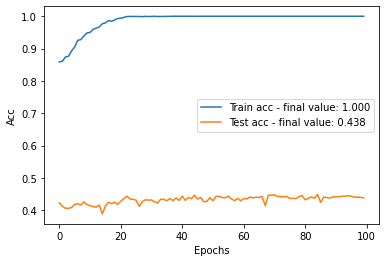

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


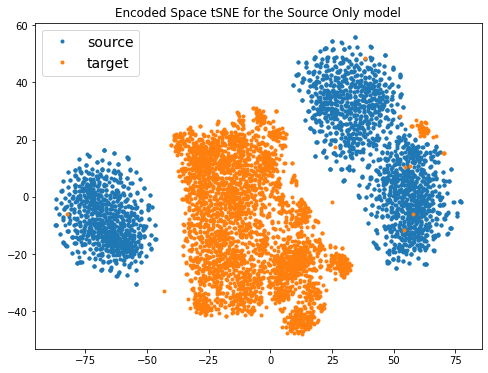

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.033581,0.987362,9.984131,0.432147
std,0.083922,0.031874,4.064893,0.011527
min,0.000004,0.858750,1.512756,0.388438
25%,0.000020,0.999062,7.694707,0.425859
50%,0.000095,1.000000,12.209770,0.435781
75%,0.003496,1.000000,13.053475,0.440937
max,0.407627,1.000000,13.910456,0.449062


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_VGG_256_RMS_0.5e-5_AU.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_2 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_2.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 28ms/step - loss: 0.6077 - acc: 0.8294 - disc_loss: 2.1633 - val_loss: 2.5312 - val_acc: 0.4737
Epoch 2/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1966 - acc: 0.9337 - disc_loss: 1.2912 - val_loss: 4.1226 - val_acc: 0.4753
Epoch 3/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1309 - acc: 0.9556 - disc_loss: 1.2507 - val_loss: 6.3336 - val_acc: 0.4834
Epoch 4/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1323 - acc: 0.9622 - disc_loss: 1.6128 - val_loss: 6.1496 - val_acc: 0.4775
Epoch 5/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1304 - acc: 0.9616 - disc_loss: 1.9808 - val_loss: 8.8427 - val_acc: 0.4803
Epoch 6/100
400/400 [==============================] - 10s 26ms/step - loss: 0.1247 - acc: 0.9672 - disc_loss: 2.3168 - val_loss: 9.3644 - val_acc: 0.4722
Epoch 7/100
400/400 [==============================] - 10s 26ms/step -

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd_2 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_2.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 18s 32ms/step - loss: 0.6114 - acc: 0.8356 - disc_loss: 2.1264 - val_loss: 2.5743 - val_acc: 0.4741
Epoch 2/100
400/400 [==============================] - 12s 29ms/step - loss: 0.1851 - acc: 0.9400 - disc_loss: 1.4265 - val_loss: 4.4657 - val_acc: 0.4697
Epoch 3/100
400/400 [==============================] - 12s 29ms/step - loss: 0.1514 - acc: 0.9550 - disc_loss: 1.2988 - val_loss: 4.4419 - val_acc: 0.4641
Epoch 4/100
400/400 [==============================] - 12s 29ms/step - loss: 0.1795 - acc: 0.9556 - disc_loss: 1.7552 - val_loss: 5.7752 - val_acc: 0.4737
Epoch 5/100
400/400 [==============================] - 12s 29ms/step - loss: 0.1548 - acc: 0.9600 - disc_loss: 2.4285 - val_loss: 6.2571 - val_acc: 0.4638
Epoch 6/100
400/400 [==============================] - 12s 29ms/step - loss: 0.1776 - acc: 0.9600 - disc_loss: 3.0054 - val_loss: 6.2776 - val_acc: 0.4666
Epoch 7/100
400/400 [==============================] - 12s 29ms/step -

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
gc.collect()

1160

In [ ]:
mdd_2 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_2.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 15s 31ms/step - loss: 0.5134 - acc: 0.9628 - disc_loss: 14.1515 - val_loss: 103.8814 - val_acc: 0.5094
Epoch 2/100
400/400 [==============================] - 12s 29ms/step - loss: 0.3619 - acc: 0.9722 - disc_loss: 15.1839 - val_loss: 149.5780 - val_acc: 0.5022
Epoch 3/100
400/400 [==============================] - 12s 29ms/step - loss: 0.4607 - acc: 0.9672 - disc_loss: 15.7053 - val_loss: 111.6127 - val_acc: 0.5109
Epoch 4/100
400/400 [==============================] - 12s 29ms/step - loss: 0.6973 - acc: 0.9497 - disc_loss: 15.7025 - val_loss: 90.0371 - val_acc: 0.5272
Epoch 5/100
400/400 [==============================] - 11s 29ms/step - loss: 0.6894 - acc: 0.9478 - disc_loss: 15.9844 - val_loss: 116.4644 - val_acc: 0.4994
Epoch 6/100
400/400 [==============================] - 12s 29ms/step - loss: 0.6541 - acc: 0.9525 - disc_loss: 15.6151 - val_loss: 125.2185 - val_acc: 0.4978
Epoch 7/100
400/400 [==============================] 

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
gc.collect()

5542

In [ ]:
mdd_2 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_2.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 16s 28ms/step - loss: 0.5436 - acc: 0.8419 - disc_loss: 1.9761 - val_loss: 2.7543 - val_acc: 0.4684
Epoch 2/100
400/400 [==============================] - 10s 25ms/step - loss: 0.1780 - acc: 0.9409 - disc_loss: 1.3174 - val_loss: 4.2795 - val_acc: 0.4753
Epoch 3/100
400/400 [==============================] - 10s 25ms/step - loss: 0.1397 - acc: 0.9588 - disc_loss: 1.3116 - val_loss: 4.9150 - val_acc: 0.4706
Epoch 4/100
400/400 [==============================] - 10s 25ms/step - loss: 0.1422 - acc: 0.9600 - disc_loss: 1.6983 - val_loss: 6.1064 - val_acc: 0.4722
Epoch 5/100
400/400 [==============================] - 10s 25ms/step - loss: 0.1702 - acc: 0.9538 - disc_loss: 2.8207 - val_loss: 7.5271 - val_acc: 0.4719
Epoch 6/100
400/400 [==============================] - 10s 25ms/step - loss: 0.1673 - acc: 0.9572 - disc_loss: 2.9371 - val_loss: 6.5507 - val_acc: 0.4584
Epoch 7/100
400/400 [==============================] - 10s 25ms/step -

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
gc.collect()

847

In [ ]:
mdd_2 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_2.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 28ms/step - loss: 0.1856 - acc: 0.9816 - disc_loss: 14.6448 - val_loss: 72.9300 - val_acc: 0.4850
Epoch 2/100
400/400 [==============================] - 10s 25ms/step - loss: 0.4032 - acc: 0.9691 - disc_loss: 15.3743 - val_loss: 125.6728 - val_acc: 0.4944
Epoch 3/100
400/400 [==============================] - 10s 25ms/step - loss: 0.4017 - acc: 0.9659 - disc_loss: 18.1987 - val_loss: 75.1560 - val_acc: 0.4834
Epoch 4/100
400/400 [==============================] - 10s 25ms/step - loss: 0.4179 - acc: 0.9625 - disc_loss: 21.2775 - val_loss: 73.0962 - val_acc: 0.4850
Epoch 5/100
400/400 [==============================] - 10s 25ms/step - loss: 0.4261 - acc: 0.9581 - disc_loss: 20.0305 - val_loss: 73.4667 - val_acc: 0.4978
Epoch 6/100
400/400 [==============================] - 10s 25ms/step - loss: 0.5882 - acc: 0.9444 - disc_loss: 17.8840 - val_loss: 109.5181 - val_acc: 0.4978
Epoch 7/100
400/400 [==============================] - 1

### Result

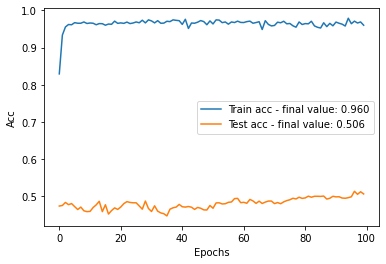

In [ ]:
acc = mdd_2.history.history["acc"]; val_acc = mdd_2.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


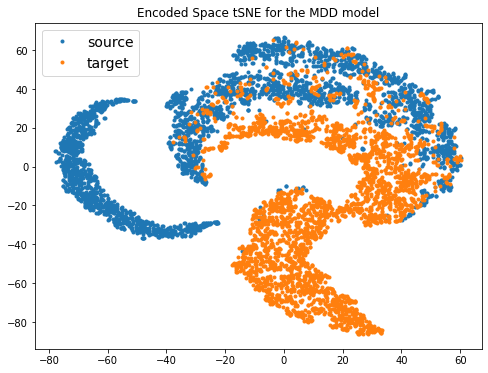

In [ ]:
LC25000_train_data_au_enc = mdd_2.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd_2.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd_2.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.371682,0.964344,9.117692,63.205933,0.480650
std,0.137039,0.015037,4.008263,44.601273,0.014245
min,0.124730,0.829375,0.539808,2.531248,0.447188
25%,0.276487,0.963047,6.488462,25.388534,0.470469
50%,0.375282,0.966250,9.531623,52.965675,0.481094
75%,0.468428,0.969219,11.637522,102.776789,0.492578
max,0.690969,0.979062,17.818533,169.357544,0.513438


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_VGG_256_RMS_ 0.5e-5_g2_AU.csv")

In [ ]:
import gc
gc.collect()

6888